# VQE using Estimator primitive and Sessions

## Background

[Variational quantum algorithms](https://arxiv.org/abs/2012.09265) are promising candidate hybrid-algorithms for observing the utility of quantum computation on noisy near-term devices. Variational algorithms are characterized by the use of a classical optimization algorithm to iteratively update a parameterized trial solution, or "ansatz". Chief among these methods is the Variational Quantum Eigensolver (VQE) that aims to solve for the ground state of a given Hamiltonian represented as a linear combination of Pauli terms, with an ansatz circuit where the number of parameters to optimize over is polynomial in the number of qubits.  Given that size of the full solution vector is exponential in the number of qubits, successful minimization using VQE requires, in general, additional problem specific information to define the structure of the ansatz circuit.


Executing a VQE algorithm requires the following 3 components:

   1. Hamiltonian and ansatz (problem specification)
   2. Qiskit Runtime estimator
   3. Classical optimizer
   
Although the Hamiltonian and ansatz require domain specific knowledge to construct, these details are immaterial to the Runtime, and we can execute a wide class of VQE problems in the same manner. 

## Setup

Here we import the tools needed for a VQE experiment.  The primary imports can be grouped logically into three components that correspond to the three required elements.

In [1]:
# General imports
import time
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# The IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Session

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

## Initialize Runtime service and select backend

Here we instantiate the Runtime service that gives access to the simulator that we use in this tutorial.

In [2]:
service = QiskitRuntimeService()

In [3]:
backend = service.get_backend("ibmq_qasm_simulator")

## Problem specification

Here we define the problem instance for our VQE algorithm.  Although the problem in question can come from a variety of domains, the form for execution via Runtime is the same.  Qiskit provides a convenience class for expressing Hamiltonians in Pauli form, and a collection of widely used ansatz circuits in the `qiskit.circuit.library`.

Here, our example Hamiltonian is derived from a quantum chemistry problem

In [4]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

and our choice of ansatz is the `EfficientSU2` that, by default, linearly entangles qubits, making it ideal for quantum hardware with limited connectivity.

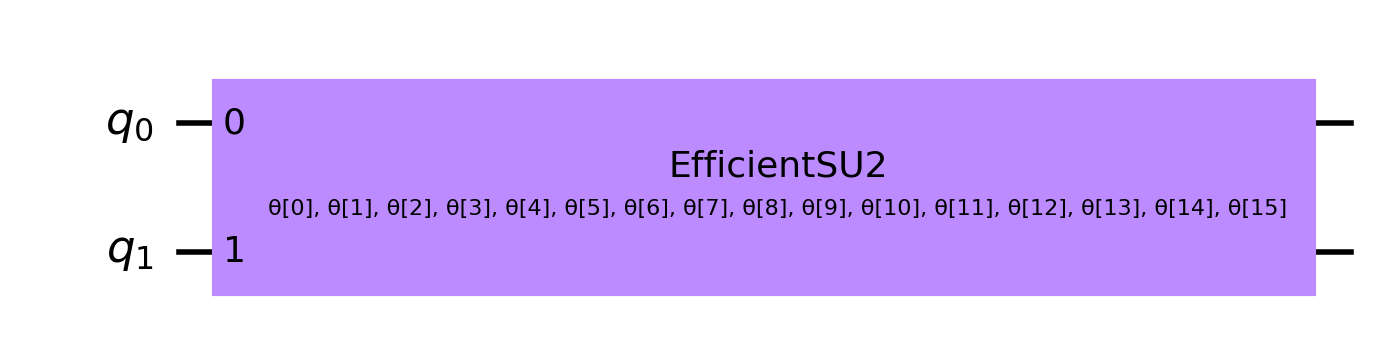

In [5]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.draw("mpl")

From the figure above we see that our ansatz circuit is defined by a vector of parameters, $\theta_{i}$, with the total number given by:

In [6]:
num_params = ansatz.num_parameters
num_params

16

## VQE cost function and minimization

Like many classical optimization problems, the solution to a VQE problem can be formulated as minimization of a scalar cost function.  By definition, VQE looks to find the ground state solution to a Hamiltonian by optimizing the ansatz circuit parameters to minimize the expectation value (energy) of the Hamiltonian.  With the Runtime `Estimator` directly taking a Hamiltonian and parameterized ansatz, and returning the necessary energy, The cost function for a VQE instance is quite simple:

In [8]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    energy = (
        estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    )
    return energy

Note that, in addition to the array of optimization parameters that must be the first argument, we use additional arguments to pass the terms needed in the cost function.

We are now free to use a classical optimizer of our choice to minimize our cost function.  Here we use the [COBYLA routine from SciPy via the `minimize` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).  Note that, when running on real quantum hardware, the choice of optimizer is important as not all optimizers handle noisy cost function landscapes equally well.

To begin the routine, we start by specifying a random initial set of parameters,

In [9]:
x0 = 2 * np.pi * np.random.random(num_params)

and because we are sending a large number of jobs that we would like to execute together, here we use a `Session` to execute all the generated circuits in one block.  Here `args` is the standard SciPy way to supply the additional parameters needed by the cost function.

In [10]:
with Session(backend=backend):
    estimator = Estimator(options={"shots": int(1e4)})
    res = minimize(
        cost_func, x0, args=(ansatz, hamiltonian, estimator), method="cobyla"
    )

KeyboardInterrupt: 

At the terminus of this routine we have a result in the standard SciPy `OptimizeResult` format.  From this we see that it took `nfev` number of cost function evaluations to obtain the solution vector of parameter angles (`x`) that, when plugged into the ansatz circuit, yield the approximate ground state solution we were looking for.

In [11]:
res

NameError: name 'res' is not defined

## Adding a callback function

As it stands now, we are unable to save intermediate results from the iteration process, view the value of the cost function per iteration, nor are we able to monitor the progress of the routine.  Callback functions are a standard way for users to obtain additional information about the status of an iterative algorithm.  The standard SciPy callback routine allows for returning only the interim vector at each iteration.  However, it is possible to do much more than this.  Here we show how to use a mutable object, such as a dictionary, to store the current vector at each iteration, for example in case we need to restart the routine due to failure, and also return the current iteration number and average time per iteration.

In [12]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        callback_dict["cost_history"].append(
            estimator.run(ansatz, hamiltonian, parameter_values=current_vector)
            .result()
            .values[0]
        )
        # Grab the current time
        current_time = time.perf_counter()
        # Find the total time of the execute (after the 1st iteration)
        if callback_dict["iters"] > 1:
            callback_dict["_total_time"] += current_time - callback_dict["_prev_time"]
        # Set the previous time to the current time
        callback_dict["_prev_time"] = current_time
        # Compute the average time per iteration and round it
        time_str = (
            round(callback_dict["_total_time"] / (callback_dict["iters"] - 1), 2)
            if callback_dict["_total_time"]
            else "-"
        )
        # Print to screen on single line
        print(
            "Iters. done: {} [Avg. time per iter: {}]".format(
                callback_dict["iters"], time_str
            ),
            end="\r",
            flush=True,
        )

    return callback

We can now repeat the experiment setting the `callback` argument in `minimize` with our function:

In [13]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "_total_time": 0,
    "_prev_time": None,
}

In [14]:
with Session(backend=backend):
    estimator = Estimator(options={"shots": int(1e4)})
    callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)
    res = minimize(
        cost_func,
        x0,
        args=(ansatz, hamiltonian, estimator),
        method="cobyla",
        callback=callback,
    )

KeyboardInterrupt: 

If the procedure terminates correctly, then the `prev_vector` and `iters` values in our `callback_dict` dictionary should be equal to the solution vector and total number of function evaluations, respectively.  This is easy to verify:

In [15]:
all(callback_dict["prev_vector"] == res.x)

NameError: name 'res' is not defined

In [16]:
callback_dict["iters"] == res.nfev

NameError: name 'res' is not defined

We can also now view the progress towards convergence as monitored by the cost history at each iteration:

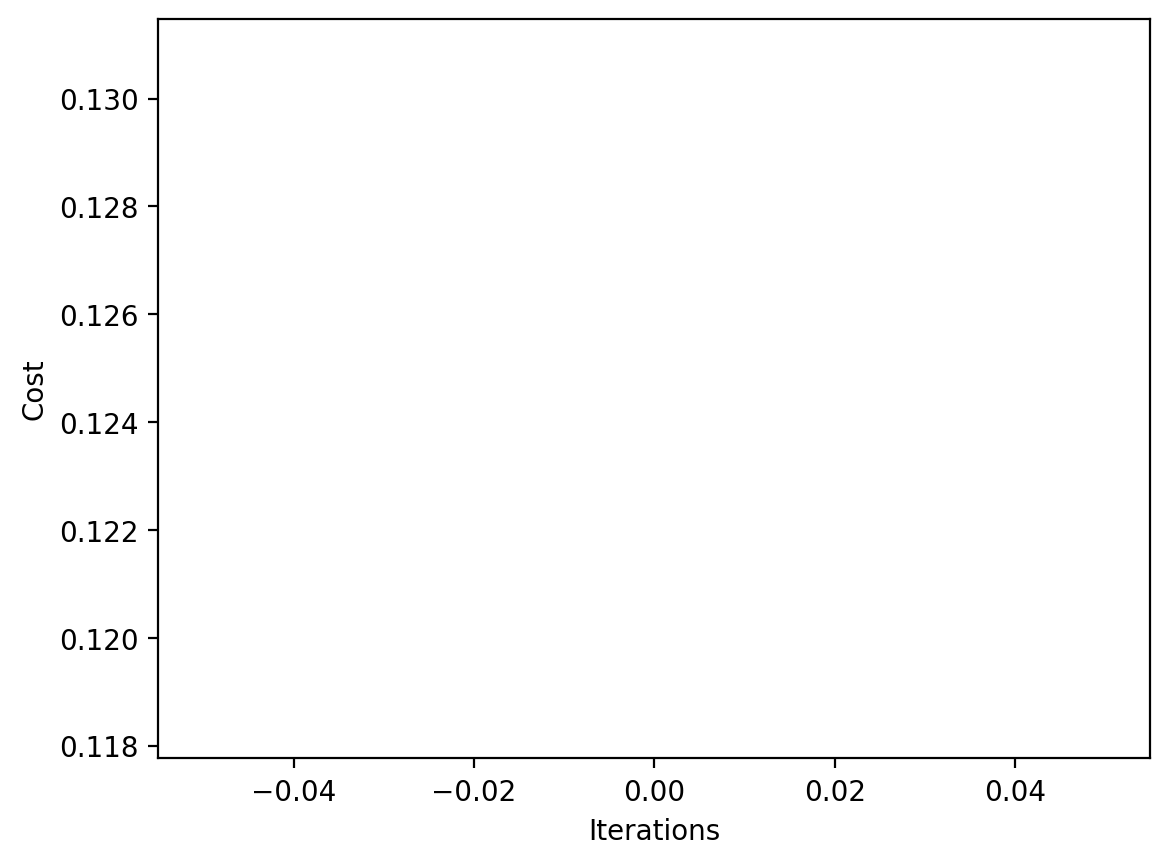

In [17]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost");

In [1]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright